In [9]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
#from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs

import gspread
from google.oauth2.service_account import Credentials

In [10]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

In [11]:
FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

# Report

In [12]:
metrics_all = pd.concat([metrics, diversity_metrics], axis=1)
metrics_all  = metrics_all.loc[:,~metrics_all.columns.duplicated()]

In [13]:
report_order = [
    'interactions', 
        'total_pageview',
        'automated_pageviews',
        'desktop', 
        'mobileweb',
        'previews_seen',
    'unique_devices',
    # Diversity
    'gn_interactions',
    'gs_interactions'
    #'Mobile-heavy wikis'
    #'mh_interactions'
]

In [14]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
    
        
    
    res = [cur, yoy_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change"]
    )

In [15]:
(
    metrics_all
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

,value,yoy_change
interactions,"20,900,000,000",14.8%
total_pageview,"19,100,000,000",16.7%
automated_pageviews,"2,790,000,000",87.0%
desktop,"6,140,000,000",-8.4%
mobileweb,"12,700,000,000",35.0%
previews_seen,"1,740,000,000",-2.8%
unique_devices,"1,600,000,000",-18.1%
gn_interactions,"15,100,000,000",7.4%
gs_interactions,"5,760,000,000",40.4%


# Update Google Sheet

In [16]:
import gspread
from google.oauth2.service_account import Credentials

In [17]:
FILE = "metrics/metrics.tsv"
all_metrics = pd.read_csv(FILE, sep="\t")

DIV_FILE = "metrics/diversity_metrics.tsv"
diversity_metrics = pd.read_csv(DIV_FILE, sep="\t")


In [18]:
all_metrics.iloc[-1,1:] = all_metrics.iloc[-1,1:].astype(float)
diversity_metrics.iloc[-1,1:] = diversity_metrics.iloc[-1,1:].astype(float)

In [20]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

credentials = Credentials.from_service_account_file('key-metrics-343717-07427b76df93.json', scopes=scope)
gc = gspread.authorize(credentials)

In [21]:
@property
def sheet1(self):
    """Shortcut property for getting the first worksheet."""
    return self.get_worksheet(0)

In [22]:
wks1 = gc.open("readers").sheet1
new_metrics = all_metrics.iloc[-1,[0,1,2,3,4,5,6,7]].tolist()
wks1.append_row(new_metrics)

{'spreadsheetId': '1mK-R8qWzKjSeHMBBek9sJsbecdic9s3r28OIW7QkqrE',
 'tableRange': 'metrics!A1:H83',
 'updates': {'spreadsheetId': '1mK-R8qWzKjSeHMBBek9sJsbecdic9s3r28OIW7QkqrE',
  'updatedRange': 'metrics!A84:H84',
  'updatedRows': 1,
  'updatedColumns': 8,
  'updatedCells': 8}}

In [23]:
# Depricated as we are no longer calculating mobile-heavy metrics
#wks2 = gc.open("readers").get_worksheet(1)
#mh_metrics = all_metrics.iloc[-1,[0,7,8,9]].tolist()
#wks2.append_row(mh_metrics)

In [24]:
wks3 = gc.open("readers").get_worksheet(1)
div_metrics = diversity_metrics.iloc[-1].tolist()
wks3.append_row(div_metrics)

{'spreadsheetId': '1mK-R8qWzKjSeHMBBek9sJsbecdic9s3r28OIW7QkqrE',
 'tableRange': 'diversity_global_market!A1:G83',
 'updates': {'spreadsheetId': '1mK-R8qWzKjSeHMBBek9sJsbecdic9s3r28OIW7QkqrE',
  'updatedRange': 'diversity_global_market!A84:G84',
  'updatedRows': 1,
  'updatedColumns': 7,
  'updatedCells': 7}}

## Create Charts

In [ ]:
# Using Hua's Viz code
%run ../key_product_metrics/wikicharts/READER_METRICS.ipynb


Changing directory to:/srv/home/mayakpwiki/High-Level-Metrics/2023-metrics/Readers-movement-metrics/Visualization
Generating Content Interactions chart...


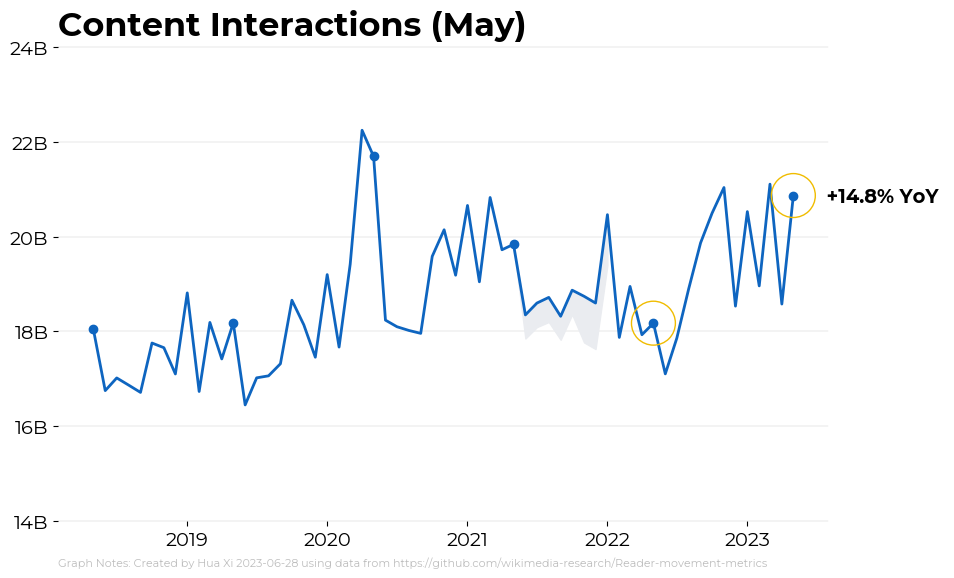

Generating Unique Devices chart...
Formatting may look incorrect in jupyter notebook window but the saved chart image will still be correct.


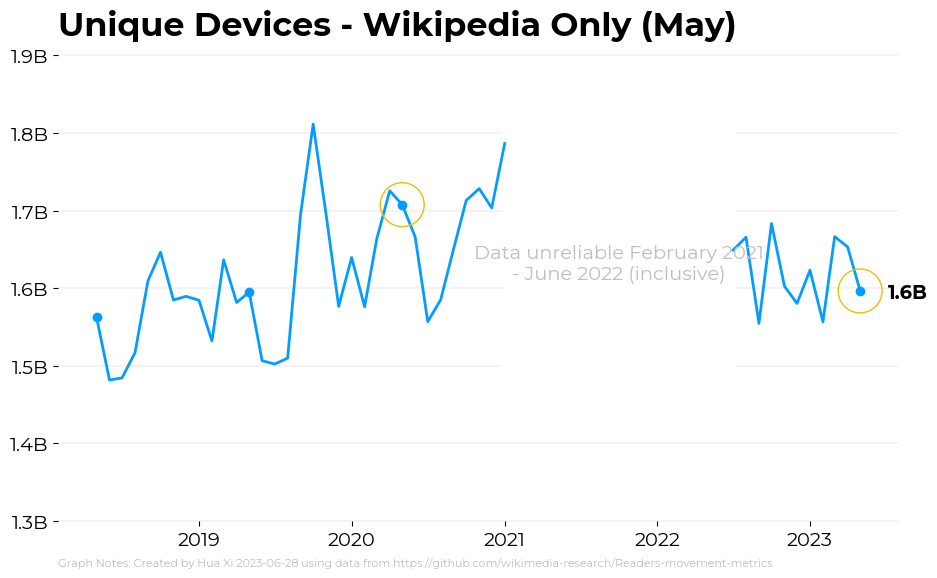

Generating Pageview Referrals chart...


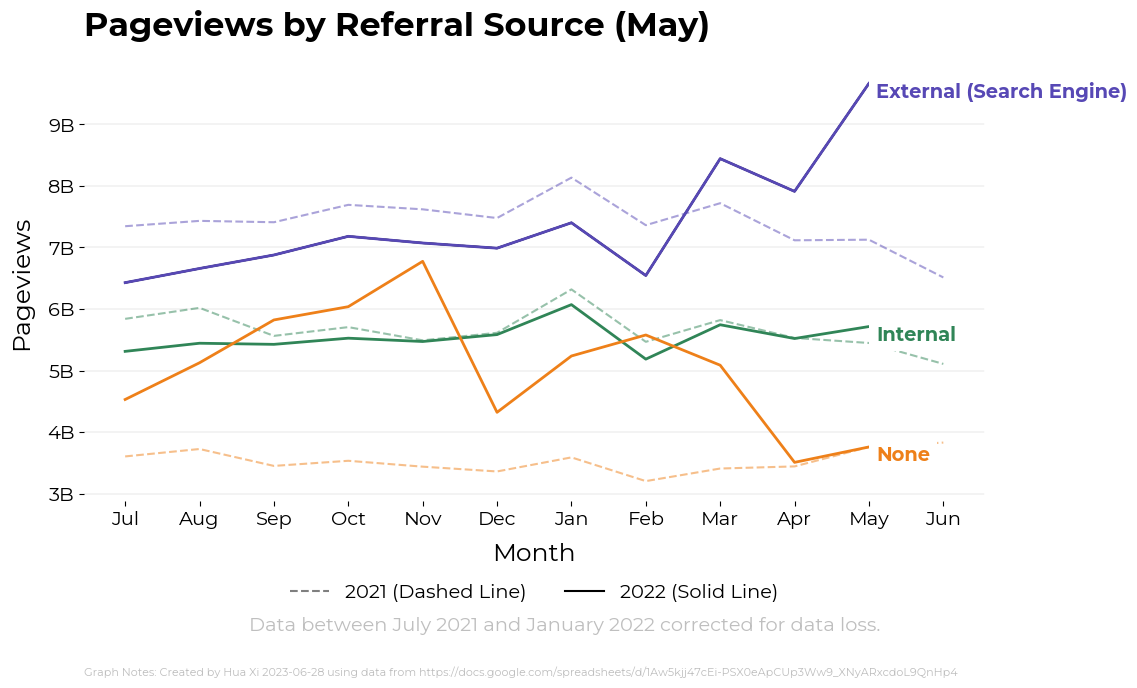

Generating Pageviews (User Only) chart...


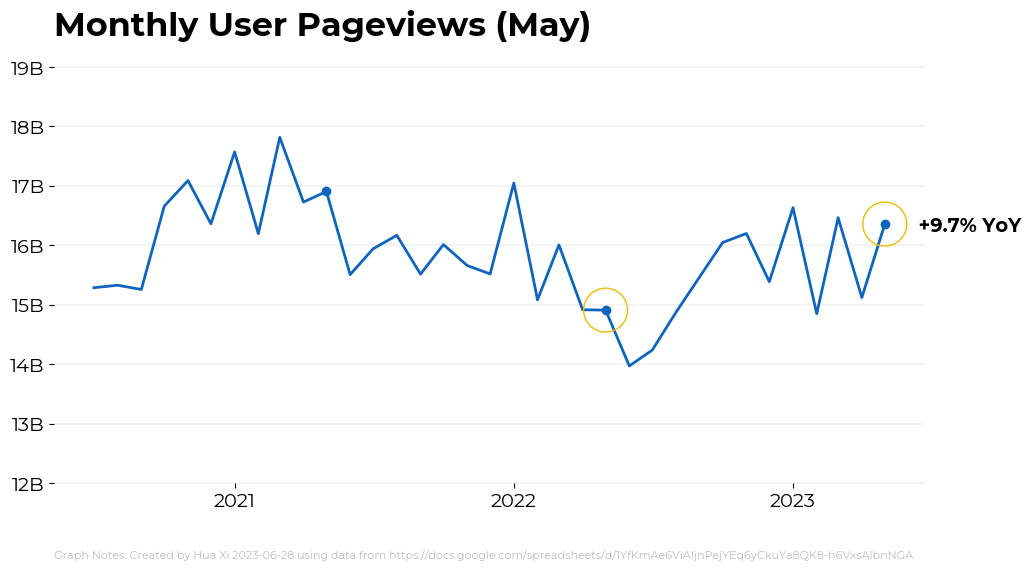

Generating Pageviews Access Method chart...
Note that even if annotation looks incorrect or cut off in jupyter notebook, the image saved in the charts folder may still be correct


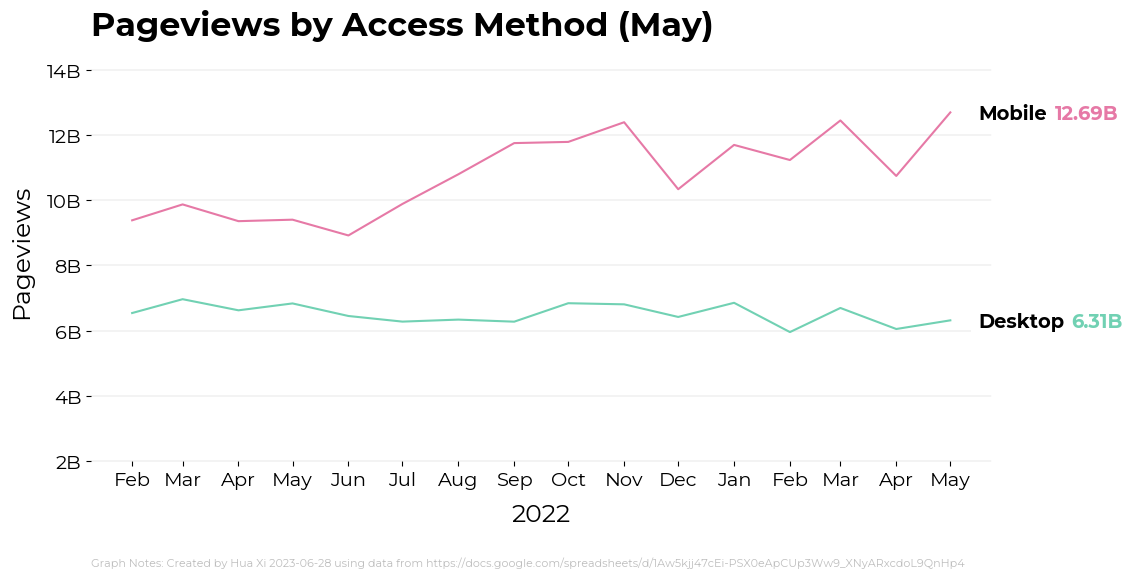

Resetting directory to:/srv/home/mayakpwiki/High-Level-Metrics/2023-metrics/Readers-movement-metrics/Visualization


In [1]:
data_path = "../metrics/metrics.tsv"
%run Visualization/READER_METRICS.ipynb